# 05. Backtesting Trading Strategy
## Realistic Trading Simulation with Transaction Costs

This notebook implements comprehensive backtesting with:
- Transaction cost modeling (50 bps)
- Position sizing and risk management
- Performance metrics calculation
- Strategy optimization

In [13]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
import joblib
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler

# Set display options
pd.set_option('display.float_format', lambda x: '%.6f' % x)
plt.style.use('seaborn-v0_8-darkgrid')

print("Libraries imported successfully!")

root_folder = '../'  # Change this to your root folder path

Libraries imported successfully!


## 1. Load Data and Best Model

In [14]:
# Load data
X_all = pd.read_csv(f'{root_folder}data/processed/engineered_features1.csv')
y = pd.read_csv(f'{root_folder}data/processed/aligned_targets1.csv').squeeze()

# Load best model info from CV
with open(f'{root_folder}data/results/best_model_cv1.json', 'r') as f:
    best_model_info = json.load(f)

print(f"Best model from CV: {best_model_info['model_name']}")
print(f"CV Performance:")
for metric, value in best_model_info['avg_metrics'].items():
    print(f"  {metric}: {value:.6f}")

# Load feature set
feature_set = best_model_info['feature_set']
X_selected = X_all[feature_set]

# Transaction cost
TRANSACTION_COST = 0.005  # 50 bps
print(f"\nTransaction cost: {TRANSACTION_COST:.3f} ({TRANSACTION_COST*100:.1f}%)")

Best model from CV: RandomForest
CV Performance:
  mse: 0.000033
  rmse: 0.005692
  direction_acc: 0.564000
  ic: 0.250492

Transaction cost: 0.005 (0.5%)


In [15]:
# Split data for backtesting
# Use last 30% for out-of-sample backtesting
train_size = int(0.7 * len(X_selected))
test_size = len(X_selected) - train_size

X_train = X_selected.iloc[:train_size]
X_test = X_selected.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

print(f"Training period: samples 0 to {train_size-1}")
print(f"Testing period: samples {train_size} to {len(X_selected)-1}")
print(f"Test set size: {test_size} samples")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training period: samples 0 to 1048
Testing period: samples 1049 to 1498
Test set size: 450 samples


## 2. Train Final Model and Generate Predictions

In [16]:
# Train the best model on full training set
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

# Select and train model based on best from CV
model_name = best_model_info['model_name']

if model_name == 'Ridge':
    model = Ridge(alpha=10.0, random_state=42)
elif model_name == 'RandomForest':
    model = RandomForestRegressor(
        n_estimators=200, max_depth=10, min_samples_split=10,
        random_state=42, n_jobs=-1
    )
elif model_name == 'XGBoost':
    model = xgb.XGBRegressor(
        n_estimators=300, max_depth=4, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8,
        random_state=42, n_jobs=-1
    )
elif model_name == 'LightGBM':
    model = lgb.LGBMRegressor(
        n_estimators=300, max_depth=5, learning_rate=0.05,
        random_state=42, n_jobs=-1, verbose=-1
    )

print(f"Training {model_name} model...")
model.fit(X_train_scaled, y_train)

# Generate predictions
train_predictions = model.predict(X_train_scaled)
test_predictions = model.predict(X_test_scaled)

print(f"Model trained. Generating predictions for backtesting...")
print(f"Prediction statistics:")
print(f"  Train - Mean: {np.mean(train_predictions):.6f}, Std: {np.std(train_predictions):.6f}")
print(f"  Test - Mean: {np.mean(test_predictions):.6f}, Std: {np.std(test_predictions):.6f}")

Training RandomForest model...
Model trained. Generating predictions for backtesting...
Prediction statistics:
  Train - Mean: 0.000255, Std: 0.003339
  Test - Mean: -0.000646, Std: 0.002411


## 3. Backtesting Engine

In [17]:
class TradingBacktester:
    """Complete backtesting engine with transaction costs."""
    
    def __init__(self, transaction_cost=0.005):
        self.transaction_cost = transaction_cost
        
    def generate_signals(self, predictions, threshold=0.0, signal_type='threshold'):
        """Generate trading signals from predictions."""
        
        if signal_type == 'threshold':
            # Threshold-based signals
            signals = np.where(predictions > threshold, 1,
                             np.where(predictions < -threshold, -1, 0))
        
        elif signal_type == 'percentile':
            # Percentile-based signals
            upper = np.percentile(predictions, 100 - threshold)
            lower = np.percentile(predictions, threshold)
            signals = np.where(predictions > upper, 1,
                             np.where(predictions < lower, -1, 0))
        
        elif signal_type == 'zscore':
            # Z-score based signals
            z_scores = (predictions - np.mean(predictions)) / np.std(predictions)
            signals = np.where(z_scores > threshold, 1,
                             np.where(z_scores < -threshold, -1, 0))
        
        return signals
    
    def calculate_returns(self, signals, actual_returns):
        """Calculate strategy returns including transaction costs."""
        
        # Calculate position changes
        positions = signals.copy()
        position_changes = np.diff(np.concatenate([[0], positions]))
        
        # Calculate transaction costs
        transaction_costs = np.abs(position_changes) * self.transaction_cost
        
        # Calculate gross and net returns
        gross_returns = positions * actual_returns
        net_returns = gross_returns - transaction_costs
        
        # Create results DataFrame
        results = pd.DataFrame({
            'signal': signals,
            'position': positions,
            'position_change': position_changes,
            'actual_return': actual_returns,
            'gross_return': gross_returns,
            'transaction_cost': transaction_costs,
            'net_return': net_returns,
            'cumulative_return': (1 + net_returns).cumprod() - 1
        })
        
        return results
    
    def calculate_metrics(self, returns):
        """Calculate performance metrics."""
        
        # Filter out any NaN values
        returns = returns[~np.isnan(returns)]
        
        # Basic metrics
        total_return = (1 + returns).prod() - 1
        n_periods = len(returns)
        annualized_return = (1 + total_return) ** (252 / n_periods) - 1
        annualized_vol = np.std(returns) * np.sqrt(252)
        
        # Risk-adjusted metrics
        sharpe_ratio = annualized_return / annualized_vol if annualized_vol > 0 else 0
        
        # Downside metrics
        downside_returns = returns[returns < 0]
        if len(downside_returns) > 0:
            downside_vol = np.std(downside_returns) * np.sqrt(252)
            sortino_ratio = annualized_return / downside_vol if downside_vol > 0 else 0
        else:
            sortino_ratio = np.inf
        
        # Drawdown
        cumulative = (1 + returns).cumprod()
        running_max = cumulative.expanding().max()
        drawdown = (cumulative - running_max) / running_max
        max_drawdown = drawdown.min()
        
        # Calmar ratio
        calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else 0
        
        # Win rate
        win_rate = np.mean(returns > 0)
        
        # Average win/loss
        winning_returns = returns[returns > 0]
        losing_returns = returns[returns < 0]
        avg_win = np.mean(winning_returns) if len(winning_returns) > 0 else 0
        avg_loss = np.mean(losing_returns) if len(losing_returns) > 0 else 0
        
        # Profit factor
        total_wins = np.sum(winning_returns) if len(winning_returns) > 0 else 0
        total_losses = abs(np.sum(losing_returns)) if len(losing_returns) > 0 else 1e-10
        profit_factor = total_wins / total_losses
        
        return {
            'total_return': total_return,
            'annualized_return': annualized_return,
            'annualized_volatility': annualized_vol,
            'sharpe_ratio': sharpe_ratio,
            'sortino_ratio': sortino_ratio,
            'max_drawdown': max_drawdown,
            'calmar_ratio': calmar_ratio,
            'win_rate': win_rate,
            'avg_win': avg_win,
            'avg_loss': avg_loss,
            'profit_factor': profit_factor,
            'num_trades': np.sum(np.abs(np.diff(returns != 0)))
        }

# Initialize backtester
backtester = TradingBacktester(transaction_cost=TRANSACTION_COST)

## 4. Threshold Optimization

In [18]:
# Optimize threshold on training data
def optimize_threshold(predictions, returns, backtester, threshold_range=None):
    """Find optimal threshold for signal generation."""
    
    if threshold_range is None:
        # Use percentiles of absolute predictions
        threshold_range = np.percentile(np.abs(predictions), np.linspace(0, 95, 50))
    
    results = []
    
    for threshold in threshold_range:
        signals = backtester.generate_signals(predictions, threshold, 'threshold')
        backtest_results = backtester.calculate_returns(signals, returns)
        metrics = backtester.calculate_metrics(backtest_results['net_return'])
        
        results.append({
            'threshold': threshold,
            'sharpe_ratio': metrics['sharpe_ratio'],
            'total_return': metrics['total_return'],
            'max_drawdown': metrics['max_drawdown'],
            'num_trades': metrics['num_trades']
        })
    
    results_df = pd.DataFrame(results)
    
    # Find optimal threshold (maximize Sharpe ratio)
    optimal_idx = results_df['sharpe_ratio'].idxmax()
    optimal_threshold = results_df.loc[optimal_idx, 'threshold']
    
    return optimal_threshold, results_df

# Optimize on training data
print("Optimizing trading threshold on training data...")
optimal_threshold, threshold_results = optimize_threshold(
    train_predictions, y_train.values, backtester
)

print(f"\nOptimal threshold: {optimal_threshold:.6f}")
print(f"Training performance at optimal threshold:")
optimal_row = threshold_results[threshold_results['threshold'] == optimal_threshold].iloc[0]
for col, val in optimal_row.items():
    if col != 'threshold':
        print(f"  {col}: {val:.4f}")

Optimizing trading threshold on training data...

Optimal threshold: 0.004002
Training performance at optimal threshold:
  sharpe_ratio: 2.3999
  total_return: 0.7189
  max_drawdown: -0.0326
  num_trades: 222.0000


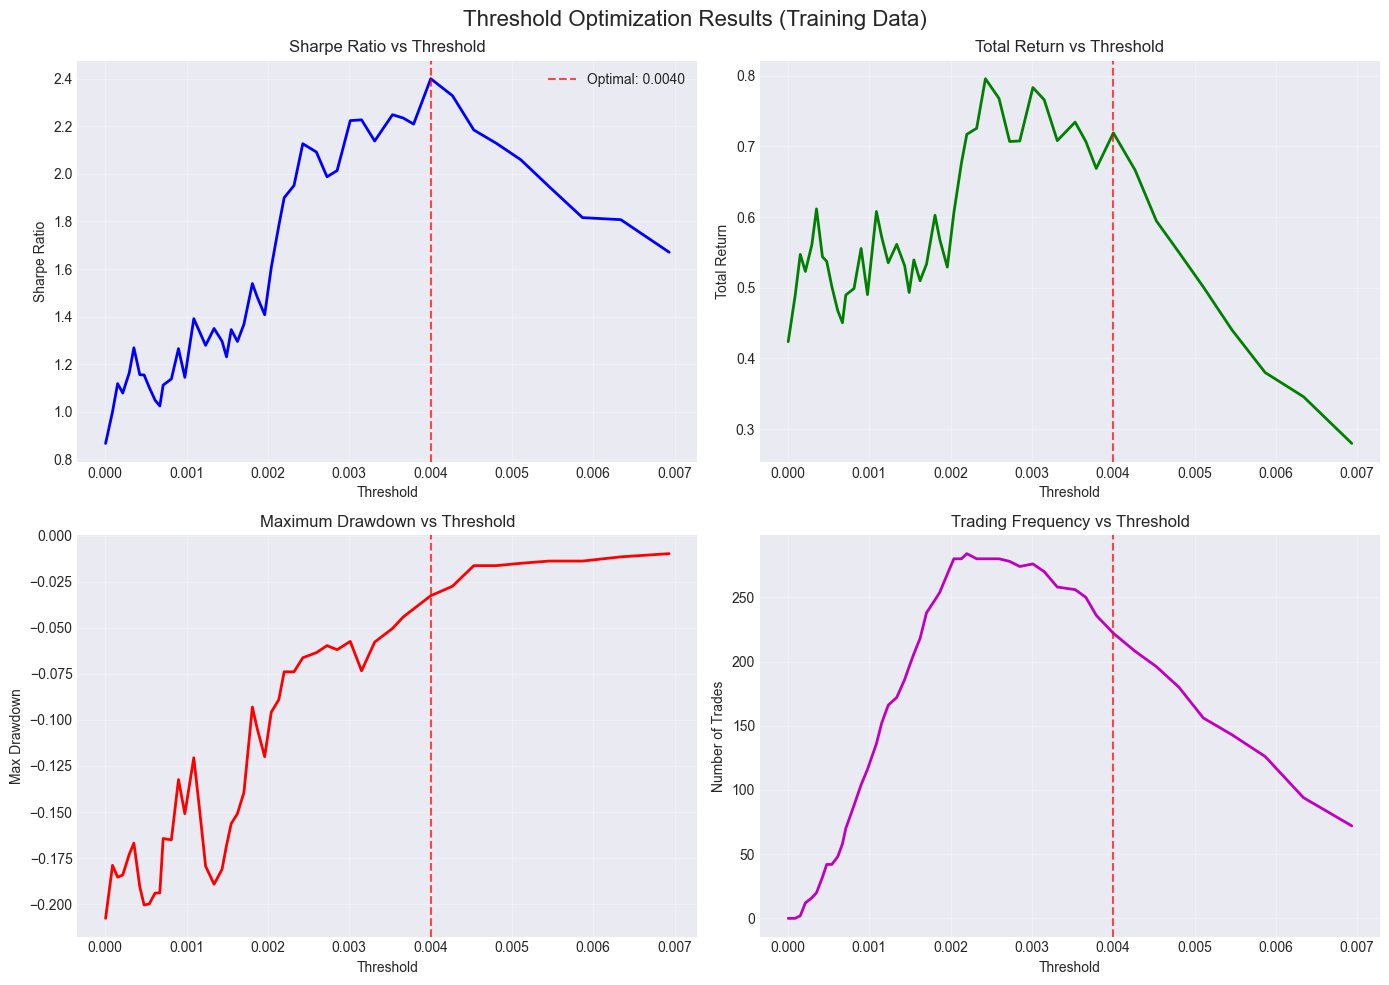

In [19]:
# Visualize threshold optimization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Sharpe ratio vs threshold
axes[0, 0].plot(threshold_results['threshold'], threshold_results['sharpe_ratio'], 'b-', linewidth=2)
axes[0, 0].axvline(x=optimal_threshold, color='red', linestyle='--', alpha=0.7, label=f'Optimal: {optimal_threshold:.4f}')
axes[0, 0].set_xlabel('Threshold')
axes[0, 0].set_ylabel('Sharpe Ratio')
axes[0, 0].set_title('Sharpe Ratio vs Threshold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Total return vs threshold
axes[0, 1].plot(threshold_results['threshold'], threshold_results['total_return'], 'g-', linewidth=2)
axes[0, 1].axvline(x=optimal_threshold, color='red', linestyle='--', alpha=0.7)
axes[0, 1].set_xlabel('Threshold')
axes[0, 1].set_ylabel('Total Return')
axes[0, 1].set_title('Total Return vs Threshold')
axes[0, 1].grid(True, alpha=0.3)

# Max drawdown vs threshold
axes[1, 0].plot(threshold_results['threshold'], threshold_results['max_drawdown'], 'r-', linewidth=2)
axes[1, 0].axvline(x=optimal_threshold, color='red', linestyle='--', alpha=0.7)
axes[1, 0].set_xlabel('Threshold')
axes[1, 0].set_ylabel('Max Drawdown')
axes[1, 0].set_title('Maximum Drawdown vs Threshold')
axes[1, 0].grid(True, alpha=0.3)

# Number of trades vs threshold
axes[1, 1].plot(threshold_results['threshold'], threshold_results['num_trades'], 'm-', linewidth=2)
axes[1, 1].axvline(x=optimal_threshold, color='red', linestyle='--', alpha=0.7)
axes[1, 1].set_xlabel('Threshold')
axes[1, 1].set_ylabel('Number of Trades')
axes[1, 1].set_title('Trading Frequency vs Threshold')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Threshold Optimization Results (Training Data)', fontsize=16)
plt.tight_layout()
plt.show()

## 5. Out-of-Sample Backtesting

In [20]:
# Run backtest on test data with optimal threshold
print("Running out-of-sample backtest...")
print(f"Using threshold: {optimal_threshold:.6f}\n")

# Generate signals
test_signals = backtester.generate_signals(test_predictions, optimal_threshold, 'threshold')

# Calculate returns
test_backtest = backtester.calculate_returns(test_signals, y_test.values)

# Calculate metrics
test_metrics = backtester.calculate_metrics(test_backtest['net_return'])

# Display results
print("Out-of-Sample Performance Metrics:")
print("="*50)
for metric, value in test_metrics.items():
    if 'return' in metric or 'ratio' in metric or 'drawdown' in metric:
        print(f"{metric:25s}: {value:12.4f}")
    else:
        print(f"{metric:25s}: {value:12.4f}")

# Compare with buy-and-hold
buy_hold_return = (1 + y_test).prod() - 1
buy_hold_annual = (1 + buy_hold_return) ** (252 / len(y_test)) - 1
buy_hold_sharpe = buy_hold_annual / (np.std(y_test) * np.sqrt(252))

print("\nBuy-and-Hold Benchmark:")
print("="*50)
print(f"{'Total Return':25s}: {buy_hold_return:12.4f}")
print(f"{'Annualized Return':25s}: {buy_hold_annual:12.4f}")
print(f"{'Sharpe Ratio':25s}: {buy_hold_sharpe:12.4f}")

# Calculate improvement
print("\nStrategy vs Buy-and-Hold:")
print("="*50)
print(f"Return Difference: {test_metrics['total_return'] - buy_hold_return:.4f}")
print(f"Sharpe Improvement: {test_metrics['sharpe_ratio'] - buy_hold_sharpe:.4f}")

Running out-of-sample backtest...
Using threshold: 0.004002

Out-of-Sample Performance Metrics:
total_return             :      -0.1791
annualized_return        :      -0.1046
annualized_volatility    :       0.0317
sharpe_ratio             :      -3.3002
sortino_ratio            :      -3.1379
max_drawdown             :      -0.1800
calmar_ratio             :      -0.5810
win_rate                 :       0.0422
avg_win                  :       0.0031
avg_loss                 :      -0.0052
profit_factor            :       0.2333
num_trades               :      55.0000

Buy-and-Hold Benchmark:
Total Return             :      -0.4150
Annualized Return        :      -0.2593
Sharpe Ratio             :      -2.7562

Strategy vs Buy-and-Hold:
Return Difference: 0.2359
Sharpe Improvement: -0.5439


## 6. Performance Visualization

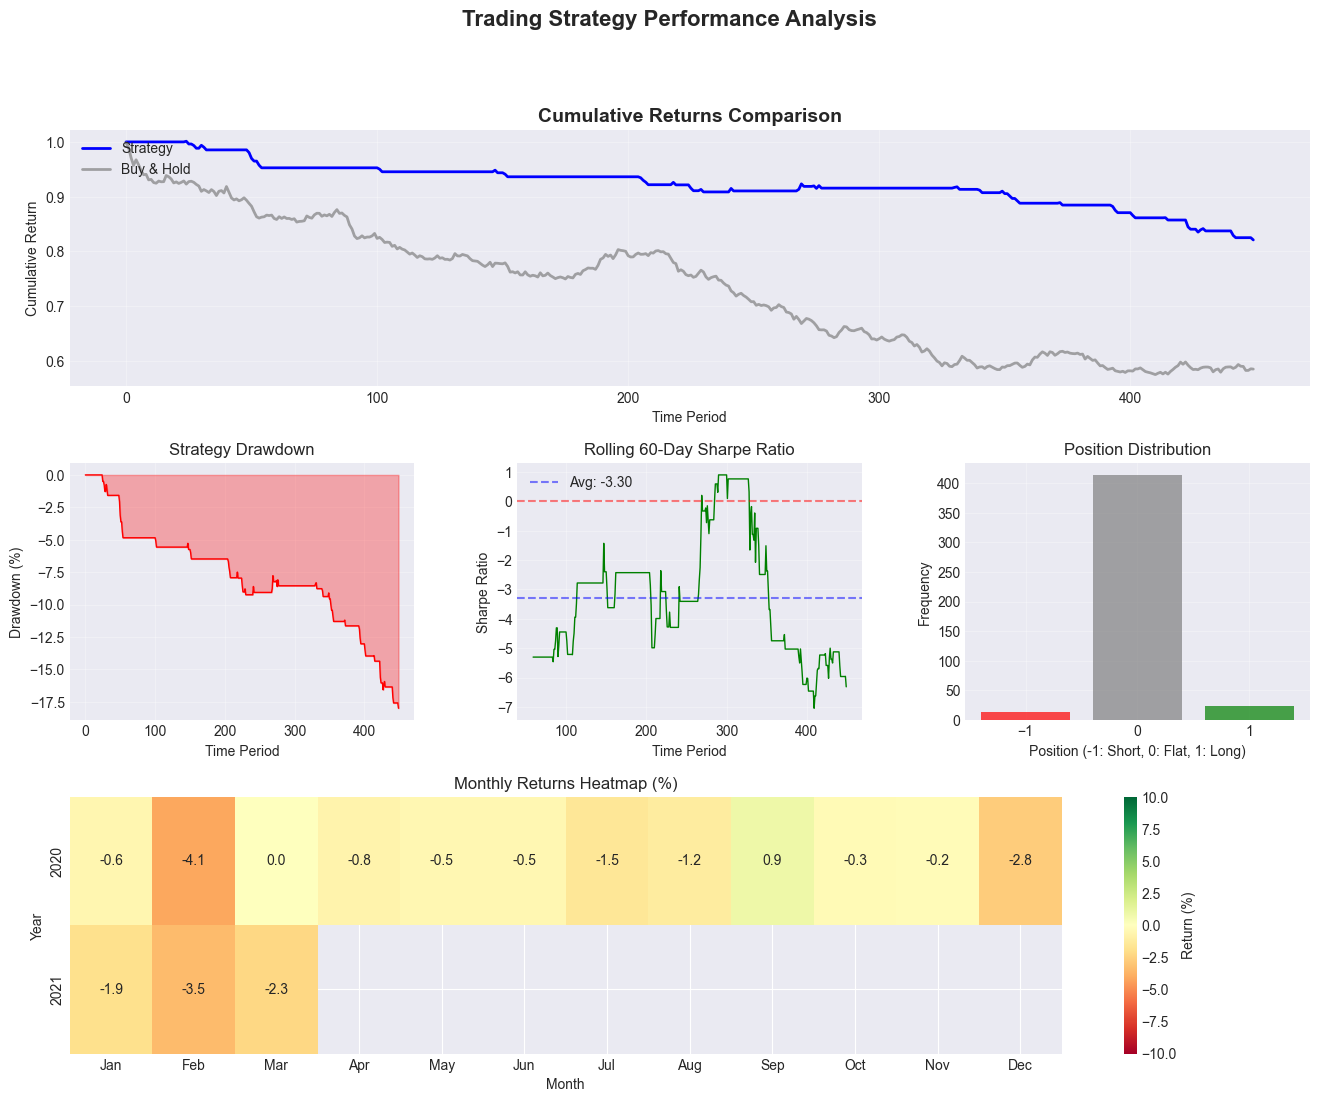

In [21]:
# Create comprehensive performance visualization
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Cumulative Returns
ax1 = fig.add_subplot(gs[0, :])
strategy_cumulative = (1 + test_backtest['net_return']).cumprod()
buyhold_cumulative = (1 + y_test).cumprod()

ax1.plot(strategy_cumulative.values, label='Strategy', linewidth=2, color='blue')
ax1.plot(buyhold_cumulative.values, label='Buy & Hold', linewidth=2, color='gray', alpha=0.7)
ax1.set_title('Cumulative Returns Comparison', fontsize=14, fontweight='bold')
ax1.set_xlabel('Time Period')
ax1.set_ylabel('Cumulative Return')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# 2. Drawdown
ax2 = fig.add_subplot(gs[1, 0])
running_max = strategy_cumulative.expanding().max()
drawdown = (strategy_cumulative - running_max) / running_max * 100

ax2.fill_between(range(len(drawdown)), drawdown.values, 0, color='red', alpha=0.3)
ax2.plot(drawdown.values, color='red', linewidth=1)
ax2.set_title('Strategy Drawdown', fontsize=12)
ax2.set_xlabel('Time Period')
ax2.set_ylabel('Drawdown (%)')
ax2.grid(True, alpha=0.3)

# 3. Rolling Sharpe Ratio (60-day)
ax3 = fig.add_subplot(gs[1, 1])
rolling_returns = pd.Series(test_backtest['net_return'].values)
rolling_sharpe = (rolling_returns.rolling(60).mean() / rolling_returns.rolling(60).std()) * np.sqrt(252)

ax3.plot(rolling_sharpe.values, color='green', linewidth=1)
ax3.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax3.axhline(y=test_metrics['sharpe_ratio'], color='blue', linestyle='--', alpha=0.5, label=f"Avg: {test_metrics['sharpe_ratio']:.2f}")
ax3.set_title('Rolling 60-Day Sharpe Ratio', fontsize=12)
ax3.set_xlabel('Time Period')
ax3.set_ylabel('Sharpe Ratio')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Position Distribution
ax4 = fig.add_subplot(gs[1, 2])
position_counts = pd.Series(test_signals).value_counts()
colors = ['red' if x == -1 else 'green' if x == 1 else 'gray' for x in position_counts.index]
ax4.bar(position_counts.index, position_counts.values, color=colors, alpha=0.7)
ax4.set_title('Position Distribution', fontsize=12)
ax4.set_xlabel('Position (-1: Short, 0: Flat, 1: Long)')
ax4.set_ylabel('Frequency')
ax4.set_xticks([-1, 0, 1])
ax4.grid(True, alpha=0.3)

# 5. Monthly Returns Heatmap
ax5 = fig.add_subplot(gs[2, :])

# Create monthly returns
test_dates = pd.date_range(start='2020-01-01', periods=len(test_backtest), freq='D')
returns_series = pd.Series(test_backtest['net_return'].values, index=test_dates)
monthly_returns = returns_series.groupby([returns_series.index.year, returns_series.index.month]).apply(lambda x: (1 + x).prod() - 1)

# Reshape for heatmap
if len(monthly_returns) > 0:
    monthly_pivot = monthly_returns.unstack(level=1)
    monthly_pivot.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    # Plot heatmap
    sns.heatmap(monthly_pivot * 100, annot=True, fmt='.1f', cmap='RdYlGn', center=0, 
                cbar_kws={'label': 'Return (%)'}, ax=ax5, vmin=-10, vmax=10)
    ax5.set_title('Monthly Returns Heatmap (%)', fontsize=12)
    ax5.set_xlabel('Month')
    ax5.set_ylabel('Year')

plt.suptitle('Trading Strategy Performance Analysis', fontsize=16, fontweight='bold')
plt.show()

## 7. Risk Analysis

In [22]:
# Risk analysis
returns = test_backtest['net_return'].values

# Value at Risk (VaR)
confidence_levels = [0.95, 0.99]
vars = {}
cvars = {}

for conf in confidence_levels:
    var = np.percentile(returns, (1 - conf) * 100)
    cvar = returns[returns <= var].mean()
    vars[conf] = var
    cvars[conf] = cvar

print("Risk Metrics:")
print("="*50)
print("\nValue at Risk (VaR):")
for conf in confidence_levels:
    print(f"  {conf*100:.0f}% VaR: {vars[conf]:.4f} ({vars[conf]*100:.2f}%)")

print("\nConditional Value at Risk (CVaR):")
for conf in confidence_levels:
    print(f"  {conf*100:.0f}% CVaR: {cvars[conf]:.4f} ({cvars[conf]*100:.2f}%)")

# Risk-adjusted returns
print("\nRisk-Adjusted Performance:")
print(f"  Information Ratio: {test_metrics['annualized_return'] / np.std(returns - y_test.mean()):.4f}")
print(f"  Omega Ratio: {np.sum(returns[returns > 0]) / abs(np.sum(returns[returns < 0])):.4f}")

# Tail ratio
right_tail = np.percentile(returns, 95)
left_tail = abs(np.percentile(returns, 5))
tail_ratio = right_tail / left_tail if left_tail != 0 else np.inf
print(f"  Tail Ratio (95/5): {tail_ratio:.4f}")

# Calculate skewness and kurtosis
print("\nDistribution Properties:")
print(f"  Skewness: {stats.skew(returns):.4f}")
print(f"  Kurtosis: {stats.kurtosis(returns):.4f}")

# Stability metrics
rolling_vol = pd.Series(returns).rolling(30).std() * np.sqrt(252)
print(f"\nVolatility Statistics:")
print(f"  Min 30-day Vol: {rolling_vol.min():.4f}")
print(f"  Max 30-day Vol: {rolling_vol.max():.4f}")
print(f"  Vol of Vol: {rolling_vol.std():.4f}")

Risk Metrics:

Value at Risk (VaR):
  95% VaR: -0.0050 (-0.50%)
  99% VaR: -0.0072 (-0.72%)

Conditional Value at Risk (CVaR):
  95% CVaR: -0.0058 (-0.58%)
  99% CVaR: -0.0102 (-1.02%)

Risk-Adjusted Performance:
  Information Ratio: -52.3884
  Omega Ratio: 0.2333
  Tail Ratio (95/5): 0.0000

Distribution Properties:
  Skewness: -1.8755
  Kurtosis: 12.2104

Volatility Statistics:
  Min 30-day Vol: 0.0000
  Max 30-day Vol: 0.0607
  Vol of Vol: 0.0167


## 8. Transaction Cost Analysis

Transaction Cost Analysis:
Total Transaction Costs: 0.3100 (31.00%)
Number of Trades: 62
Average Cost per Trade: 0.0050 (0.50%)

Return Impact:
  Gross Total Return: 0.1196 (11.96%)
  Net Total Return: -0.1791 (-17.91%)
  Cost Drag: 0.2986 (29.86%)

Break-even Win Rate: 51.65%


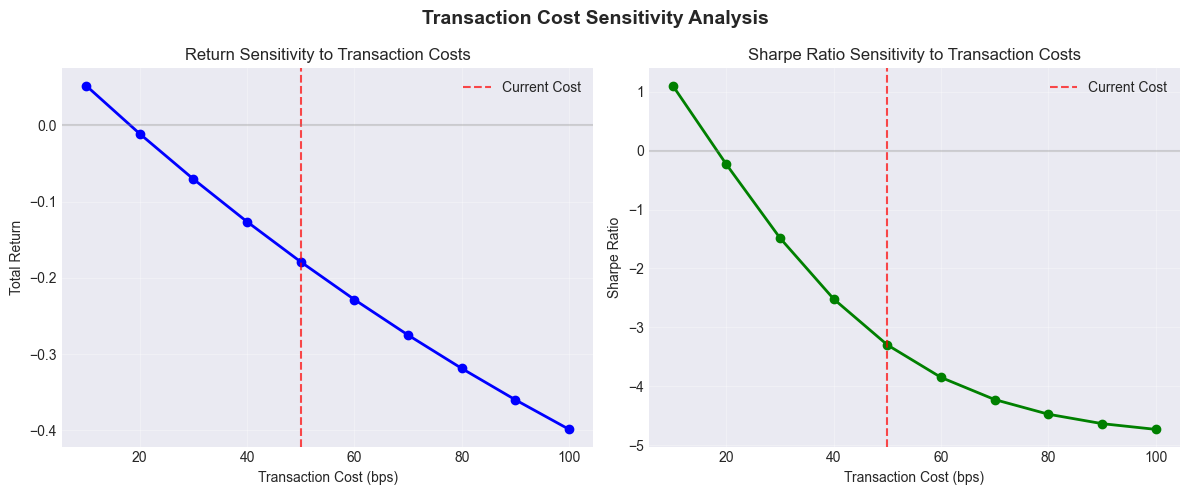

In [23]:
# Analyze impact of transaction costs
transaction_costs = test_backtest['transaction_cost'].values
gross_returns = test_backtest['gross_return'].values
net_returns = test_backtest['net_return'].values

# Calculate cost impact
total_transaction_costs = np.sum(transaction_costs)
gross_total_return = (1 + gross_returns).prod() - 1
net_total_return = (1 + net_returns).prod() - 1
cost_drag = gross_total_return - net_total_return

# Trading statistics
n_trades = np.sum(test_backtest['position_change'] != 0)
avg_cost_per_trade = total_transaction_costs / n_trades if n_trades > 0 else 0

print("Transaction Cost Analysis:")
print("="*50)
print(f"Total Transaction Costs: {total_transaction_costs:.4f} ({total_transaction_costs*100:.2f}%)")
print(f"Number of Trades: {n_trades}")
print(f"Average Cost per Trade: {avg_cost_per_trade:.4f} ({avg_cost_per_trade*100:.2f}%)")
print(f"\nReturn Impact:")
print(f"  Gross Total Return: {gross_total_return:.4f} ({gross_total_return*100:.2f}%)")
print(f"  Net Total Return: {net_total_return:.4f} ({net_total_return*100:.2f}%)")
print(f"  Cost Drag: {cost_drag:.4f} ({cost_drag*100:.2f}%)")
print(f"\nBreak-even Win Rate: {TRANSACTION_COST / (2 * np.mean(np.abs(y_test))):.2%}")

# Sensitivity analysis
cost_levels = np.array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.010])
sensitivity_results = []

for cost in cost_levels:
    temp_backtester = TradingBacktester(transaction_cost=cost)
    temp_results = temp_backtester.calculate_returns(test_signals, y_test.values)
    temp_metrics = temp_backtester.calculate_metrics(temp_results['net_return'])
    
    sensitivity_results.append({
        'cost_bps': cost * 10000,
        'total_return': temp_metrics['total_return'],
        'sharpe_ratio': temp_metrics['sharpe_ratio']
    })

sensitivity_df = pd.DataFrame(sensitivity_results)

# Plot sensitivity
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(sensitivity_df['cost_bps'], sensitivity_df['total_return'], 'b-', linewidth=2, marker='o')
axes[0].axvline(x=TRANSACTION_COST*10000, color='red', linestyle='--', alpha=0.7, label='Current Cost')
axes[0].axhline(y=0, color='gray', linestyle='-', alpha=0.3)
axes[0].set_xlabel('Transaction Cost (bps)')
axes[0].set_ylabel('Total Return')
axes[0].set_title('Return Sensitivity to Transaction Costs')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(sensitivity_df['cost_bps'], sensitivity_df['sharpe_ratio'], 'g-', linewidth=2, marker='o')
axes[1].axvline(x=TRANSACTION_COST*10000, color='red', linestyle='--', alpha=0.7, label='Current Cost')
axes[1].axhline(y=0, color='gray', linestyle='-', alpha=0.3)
axes[1].set_xlabel('Transaction Cost (bps)')
axes[1].set_ylabel('Sharpe Ratio')
axes[1].set_title('Sharpe Ratio Sensitivity to Transaction Costs')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Transaction Cost Sensitivity Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 9. Save Backtest Results

In [24]:
# Save all results
backtest_summary = {
    'model': model_name,
    'optimal_threshold': optimal_threshold,
    'transaction_cost': TRANSACTION_COST,
    'test_metrics': test_metrics,
    'benchmark_metrics': {
        'total_return': buy_hold_return,
        'annualized_return': buy_hold_annual,
        'sharpe_ratio': buy_hold_sharpe
    },
    'cost_analysis': {
        'total_costs': total_transaction_costs,
        'num_trades': n_trades,
        'cost_drag': cost_drag
    },
    'risk_metrics': {
        'var_95': vars[0.95],
        'var_99': vars[0.99],
        'cvar_95': cvars[0.95],
        'cvar_99': cvars[0.99]
    }
}

# Save summary
with open(f'{root_folder}data/results/backtest_summary1.json', 'w') as f:
    json.dump(backtest_summary, f, indent=2, default=float)
print("✓ Saved backtest summary")

# Save detailed results
test_backtest.to_csv(f'{root_folder}data/results/backtest_details1.csv', index=False)
print("✓ Saved detailed backtest results")

# Save sensitivity analysis
sensitivity_df.to_csv(f'{root_folder}data/results/cost_sensitivity1.csv', index=False)
print("✓ Saved cost sensitivity analysis")

print("\n" + "="*60)
print("BACKTEST COMPLETE")
print("="*60)
print(f"Model: {model_name}")
print(f"Out-of-Sample Sharpe Ratio: {test_metrics['sharpe_ratio']:.4f}")
print(f"Out-of-Sample Total Return: {test_metrics['total_return']:.4f}")
print(f"Maximum Drawdown: {test_metrics['max_drawdown']:.4f}")
print("="*60)

✓ Saved backtest summary
✓ Saved detailed backtest results
✓ Saved cost sensitivity analysis

BACKTEST COMPLETE
Model: RandomForest
Out-of-Sample Sharpe Ratio: -3.3002
Out-of-Sample Total Return: -0.1791
Maximum Drawdown: -0.1800
